In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:
bag = rosbag.Bag('/home/uware/rosbags/static/rotation/21h7/s_yaw_21h7_5m_360_30.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60,75]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,-10.342525
1,0.636512,10.163767
2,37.310010,19.838194
3,50.673191,47.047783
4,51.440906,11.480851


<AxesSubplot:xlabel='relative_time'>

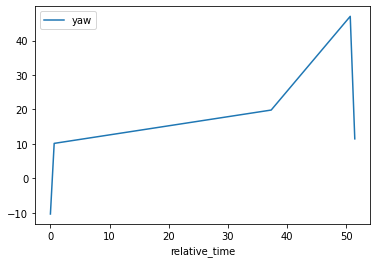

In [5]:
# initial graph
df.plot(x='relative_time', y=target)

In [6]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 1)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [7]:
# the amount of data points we are left with
len(x[peaks])

0

In [8]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

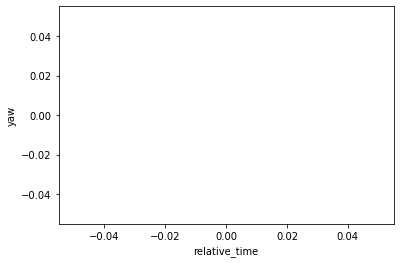

In [9]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [10]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

ValueError: Cannot cut empty array

In [ ]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [ ]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [ ]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,yaw,true_yaw,error
5,2.276478,24.006980,60,35.993020
9,2.542638,22.130522,60,37.869478
180,17.211153,-28.054645,0,28.054645
237,20.110735,-25.315458,0,25.315458
587,32.281546,30.303911,75,44.696089
598,32.648080,30.201388,75,44.798612


In [ ]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,4.0,28.427901,5.312073,24.307616,25.063498,26.685051,30.049455,36.033884
15,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,105.0,36.856923,4.691914,30.185342,31.610466,37.869478,41.580822,43.031567
75,22.0,36.772172,5.681503,31.914036,32.579954,33.859283,44.730868,45.099654


In [ ]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

KeyError: 15

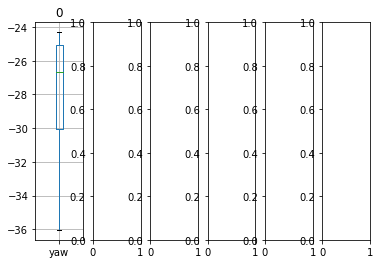

In [ ]:
box_plotter(target)

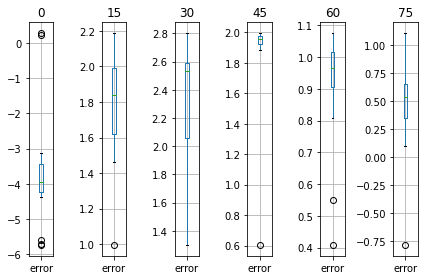

In [ ]:
box_plotter('error')